# Course 2 Project: ML Pipeline for Feature Engineering

## Instructions

In this project, you'll use data related to microeconomic indicators and historical stock prices to explore the data engineering pipline. You'll get to practice:

* Data ingestion 
* Data cleaning
* Data imputation
* Exploratory data analysis (EDA) through charts and graphs

## Packages

You'll use `pandas` and `matplotlib`, which were covered in the course material, to import, clean, and plot data. They have been installed in this workspace for you. If you're working locally and you installed Jupyter using Anaconda, these packages will already be installed. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import MonthEnd
from sklearn.preprocessing import StandardScaler


## Load data

The first step in a data engineering pipeline for machine learning is to ingest the data that will be used. For this project, data is hosted on a public GitHub repo. 

### Your tasks
* Import data from the provided [GitHub repo](https://github.com/udacity/CD13649-Project/tree/main/Project) using `pandas`. For your convenience, the data files (CSVs) are also present in the current workspace at the path **CD13649-Project/Project/**. Here are the data files to import: 
  1. GDP (**GDP.csv**)
  2. Inflation (**inflation_monthly.csv**)
  3. Apple stock prices (**apple_historical_data.csv**)
  4. Microsoft stock prices (**microsoft_historical_data.csv**)
  5. Consumer price index (**consumer_price_index.csv**)



* Verify that the data has been imported correctly into `pandas` dataframes. Use methods like `head()` and `info()`


* You may need to change column names to make them easier to work with


* You may need to cast datetime data to the `datetime` format using `pandas` `to_datetime()` method



In [2]:
# Load historical GDP data from GitHub raw URLs
base_url = 'https://raw.githubusercontent.com/udacity/CD13649-Project/main/Project/'
gdp_df = pd.read_csv(base_url + 'GDP.csv')
inflation_df = pd.read_csv(base_url + 'inflation_monthly.csv')
apple_df = pd.read_csv(base_url + 'apple_historical_data.csv')
microsoft_df = pd.read_csv(base_url + 'microsoft_historical_data.csv')
cpi_df = pd.read_csv(base_url + 'consumer_price_index.csv')


In [3]:
# Check the first few rows of data
print("GDP Data:")
print(gdp_df.head())
print("\nGDP Info:")
print(gdp_df.info())
print("\n" + "="*50)
print("\nInflation Data:")
print(inflation_df.head())
print("\nInflation Info:")
print(inflation_df.info())


GDP Data:
         DATE      GDP
0  1947-01-01  243.164
1  1947-04-01  245.968
2  1947-07-01  249.585
3  1947-10-01  259.745
4  1948-01-01  265.742

GDP Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    309 non-null    object 
 1   GDP     309 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.0+ KB
None


Inflation Data:
         DATE  CORESTICKM159SFRBATL
0  1968-01-01              3.651861
1  1968-02-01              3.673819
2  1968-03-01              4.142164
3  1968-04-01              4.155828
4  1968-05-01              4.088245

Inflation Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 675 entries, 0 to 674
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   DATE                  675 non-null    object 
 1   CORESTICKM159SFRBAT

## Data preprocessing: Check for missing data and forward fill

Check the Apple historical prices for missing data. Check for missing data in all columns. If there's data missing, use a forward fill to fill in those missing prices. 

In [4]:
# Check for nulls 
print("Apple missing data:")
print(apple_df.isnull().sum())
print("\nApple missing data percentage:")
print(apple_df.isnull().sum() / len(apple_df) * 100)

Apple missing data:
Date          0
Close/Last    3
Volume        0
Open          0
High          0
Low           0
dtype: int64

Apple missing data percentage:
Date          0.00000
Close/Last    0.11919
Volume        0.00000
Open          0.00000
High          0.00000
Low           0.00000
dtype: float64


In [5]:
# Forward fill any missing data
# First, ensure Date column is datetime and set as index for forward fill
apple_df['Date'] = pd.to_datetime(apple_df['Date'])
apple_df = apple_df.sort_values('Date')
apple_df = apple_df.set_index('Date')
apple_df = apple_df.fillna(method='ffill')  # Forward fill

/tmp/ipykernel_357793/3074042955.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  apple_df = apple_df.fillna(method='ffill')  # Forward fill


In [6]:
# Check again for nulls after using forward fill
print("Apple missing data after forward fill:")
print(apple_df.isnull().sum())


Apple missing data after forward fill:
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64


In [7]:
# Check for nulls 
print("Microsoft missing data:")
print(microsoft_df.isnull().sum())
print("\Microsoft missing data percentage:")
print(microsoft_df.isnull().sum() / len(microsoft_df) * 100)

Microsoft missing data:
Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64
\Microsoft missing data percentage:
Date          0.0
Close/Last    0.0
Volume        0.0
Open          0.0
High          0.0
Low           0.0
dtype: float64


## Data preprocessing: Remove special characters and convert to numeric/datetime

The next step in the data engineering process is to standardize and clean up data. In this step, you'll check for odd formatting and special characters that will make it difficult to work with data as numeric or datetime. 

In this step:
* Convert any columns with date/time data into a `pandas` `datetime` format
* Create a function that takes in a dataframe and a list of columns and removes dollar signs ('$') from those columns

In [8]:

def convert_dollar_columns_to_numeric(df, numeric_columns):
    '''
        Removes dollar signs ('$') from a list of columns in a given dataframe AND casts the columns to a numeric datatype.
        Updates dataframe IN PLACE.
        
        Inputs:
            df: dataframe to be operated on
            numeric_columns: columns that should have numeric data but have dollar signs currently
            
        Returns:
            None - changes to the dataframe can be made in place
    '''
    for col in numeric_columns:
        if col in df.columns:
            # Remove dollar signs and any whitespace, then convert to numeric
            df[col] = df[col].astype(str).str.replace('$', '').str.strip()
            df[col] = pd.to_numeric(df[col], errors='coerce')

In [9]:
# Use convert_dollar_columns_to_numeric() to remove the dollar sign from the Apple and Microsoft datasets
# Reset index if Date is the index
if apple_df.index.name == 'Date':
    apple_df = apple_df.reset_index()
if 'Date' in microsoft_df.columns:
    microsoft_df['Date'] = pd.to_datetime(microsoft_df['Date'])
    microsoft_df = microsoft_df.sort_values('Date')

# Convert dollar columns to numeric
price_columns = ['Close/Last', 'Open', 'High', 'Low']
convert_dollar_columns_to_numeric(apple_df, price_columns)
convert_dollar_columns_to_numeric(microsoft_df, price_columns)

## Data preprocessing: Align datetime data

Data engineering includes changing data with a datetime component if needed so that different time series can be more easily compared or plotted against each other. 

In this step:

* Align the inflation date so that it falls on the last day of the month instead of the first

Helpful hints: 
* Use the `pandas` `offsets` method using `MonthEnd(0)` to set the 'Date' column to month-end

In [10]:
# Align inflation data so that the date is the month end (e.g. Jan 31, Feb 28/29)
# First ensure DATE is datetime if not already
if 'DATE' in inflation_df.columns:
    inflation_df['DATE'] = pd.to_datetime(inflation_df['DATE'])
    inflation_df['DATE'] = inflation_df['DATE'] + MonthEnd(0)
elif 'Date' in inflation_df.columns:
    inflation_df['Date'] = pd.to_datetime(inflation_df['Date'])
    inflation_df['Date'] = inflation_df['Date'] + MonthEnd(0)

## Data preprocessing: Upsample, downsample and interpolate data

Inflation data is presented monthly in this dataset. However, for some models, you may need it at a quarterly frequency, and for some models you may need it at a weekly frequency. 

In this step:
* Create a new quarterly inflation dataframe by downsampling the monthly inflation data to quarterly using the mean (e.g. for quarter 1 in a given year, use the average values from January, February, and March)
* Create a new weekly inflation dataframe by upsampling the monthly inflation data. For this, you'll need to use `resample` and then you'll need to `interpolate` to fill in the missing data at the weekly frequency

Note that you may need to change the index for some of these operations! 

In [11]:
# Create quarterly and weekly inflation dataframes
# Ensure DATE column is datetime and set as index (works if column is 'DATE')
if 'DATE' in inflation_df.columns:
    inflation_df['DATE'] = pd.to_datetime(inflation_df['DATE'])
    inflation_df_indexed = inflation_df.set_index('DATE').sort_index()
elif 'Date' in inflation_df.columns:
    inflation_df['Date'] = pd.to_datetime(inflation_df['Date'])
    inflation_df_indexed = inflation_df.set_index('Date').sort_index()
else:
    inflation_df_indexed = inflation_df.set_index(inflation_df.columns[0]).sort_index()

# Downsample monthly inflation to quarterly using the mean (quarter-end)
inflation_quarterly = inflation_df_indexed.resample('Q').mean()

# Upsample monthly inflation to weekly and interpolate missing values (time-based interpolation)
# Use asfreq() to create weekly timestamps, then interpolate numeric columns
inflation_weekly = inflation_df_indexed.resample('W').asfreq()
inflation_weekly = inflation_weekly.interpolate(method='time')

# Display samples and shapes
print('Inflation monthly sample:')
print(inflation_df_indexed.head())
print('Inflation quarterly (resampled) sample:')
print(inflation_quarterly.head())
print(f'Inflation quarterly shape: {inflation_quarterly.shape}')
print('Inflation weekly (upsampled+interpolated) sample:')
print(inflation_weekly.head())
print(f'Inflation weekly shape: {inflation_weekly.shape}')


Inflation monthly sample:
            CORESTICKM159SFRBATL
DATE                            
1968-01-31              3.651861
1968-02-29              3.673819
1968-03-31              4.142164
1968-04-30              4.155828
1968-05-31              4.088245
Inflation quarterly (resampled) sample:
            CORESTICKM159SFRBATL
DATE                            
1968-03-31              3.822615
1968-06-30              4.263214
1968-09-30              4.882643
1968-12-31              5.429443
1969-03-31              5.873770
Inflation quarterly shape: (225, 1)
Inflation weekly (upsampled+interpolated) sample:
            CORESTICKM159SFRBATL
DATE                            
1968-02-04                   NaN
1968-02-11                   NaN
1968-02-18                   NaN
1968-02-25                   NaN
1968-03-03                   NaN
Inflation weekly shape: (2931, 1)


## Data preprocessing: Normalize/standardize a feature

Economic time series data often involve variables measured on different scales (e.g., GDP in trillions of dollars, inflation in percentage points). Standardizing these variables (typically by subtracting the mean and dividing by the standard deviation) puts them on a common scale, allowing for meaningful comparisons and analyses.

Your task:
* Standardize the GDP data. You may do this manually by subtracting the mean and dividing by the standard deviation, or you may use a built-in method from a library like `sklearn`'s `StandardScaler`

In [12]:
# Standardize the GDP data using sklearn's StandardScaler
scaler = StandardScaler()
gdp_df['GDP_standardized'] = scaler.fit_transform(gdp_df[['GDP']])

# Alternatively, you can do it manually:
# gdp_mean = gdp_df['GDP'].mean()
# gdp_std = gdp_df['GDP'].std()
# gdp_df['GDP_standardized'] = (gdp_df['GDP'] - gdp_mean) / gdp_std

print("GDP Data with Standardized Column:")
print(gdp_df.head())
print("\nGDP Standardized Statistics:")
print(gdp_df['GDP_standardized'].describe())


GDP Data with Standardized Column:
         DATE      GDP  GDP_standardized
0  1947-01-01  243.164         -0.935496
1  1947-04-01  245.968         -0.935121
2  1947-07-01  249.585         -0.934636
3  1947-10-01  259.745         -0.933276
4  1948-01-01  265.742         -0.932472

GDP Standardized Statistics:
count    3.090000e+02
mean    -1.839593e-16
std      1.001622e+00
min     -9.354964e-01
25%     -8.602482e-01
50%     -3.805131e-01
75%      7.097946e-01
max      2.820281e+00
Name: GDP_standardized, dtype: float64


## EDA: Plotting a time series of adjusted open vs close price

As part of your EDA, you'll frequently want to plot two time series on the same graph and using the same axis to compare their movements. 

Your task:
* Plot the Apple open and close price time series on the same chart **for the last three months only**. Be sure to use a legend to label each line

**NOTE**: This is a large dataset. If you try to plot the entire series, your graph will be hard to interpret and may take a long time to plot. Be sure to use only the most recent three months of data. 

In [13]:
# Get max date in timeseries and use it to get the last three months of data
# Reset index if Date is the index
if apple_df.index.name == 'Date':
    apple_df = apple_df.reset_index()
    
max_date = apple_df['Date'].max()
three_months_ago = max_date - pd.DateOffset(months=3)
apple_last_3_months = apple_df[apple_df['Date'] >= three_months_ago].copy()
print(f"Max date in Apple dataset: {max_date}")
print(f"Last 3 months data shape: {apple_last_3_months.shape}")
print(f"Date range: {apple_last_3_months['Date'].min()} to {apple_last_3_months['Date'].max()}")


Max date in Apple dataset: 2024-05-03 00:00:00
Last 3 months data shape: (63, 6)
Date range: 2024-02-05 00:00:00 to 2024-05-03 00:00:00


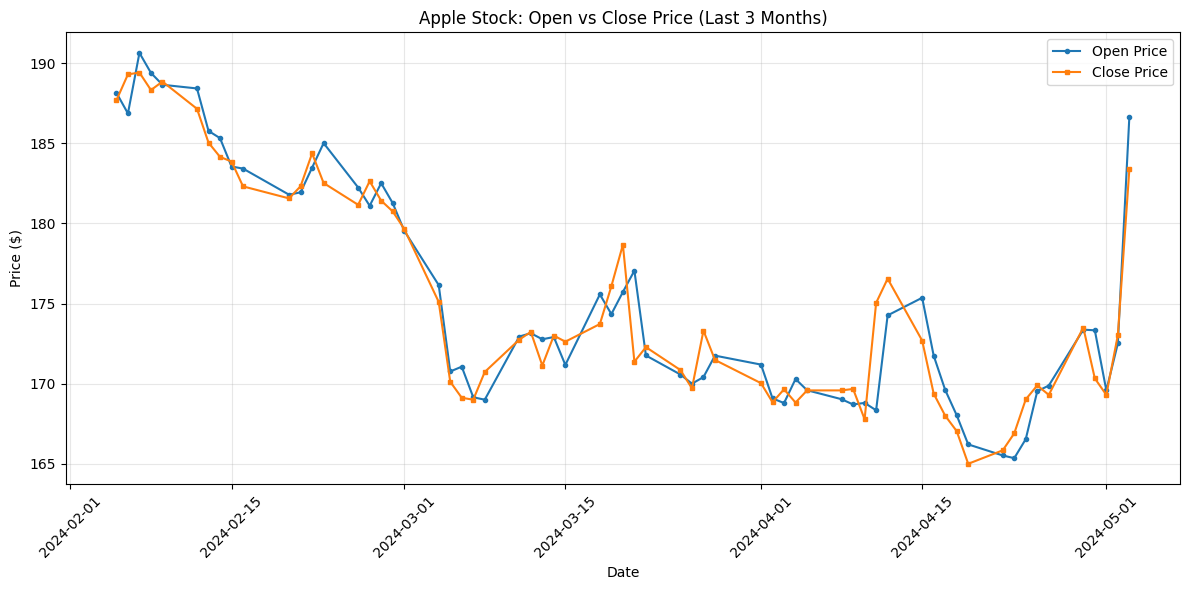

In [14]:
# Plot time series of open v. close stock price for Apple using the last 3 months of data
plt.figure(figsize=(12, 6))
plt.plot(apple_last_3_months['Date'], apple_last_3_months['Open'], label='Open Price', marker='o', markersize=3)
plt.plot(apple_last_3_months['Date'], apple_last_3_months['Close/Last'], label='Close Price', marker='s', markersize=3)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title('Apple Stock: Open vs Close Price (Last 3 Months)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## EDA: Plotting a histogram of a stock's closing price in the last three months

One way to see how much a stock's price generally moves is to plot the frequency of closing prices over a set time period. 

Your task:
* Use the **last three months** of Apple stock data and plot a histogram of closing price

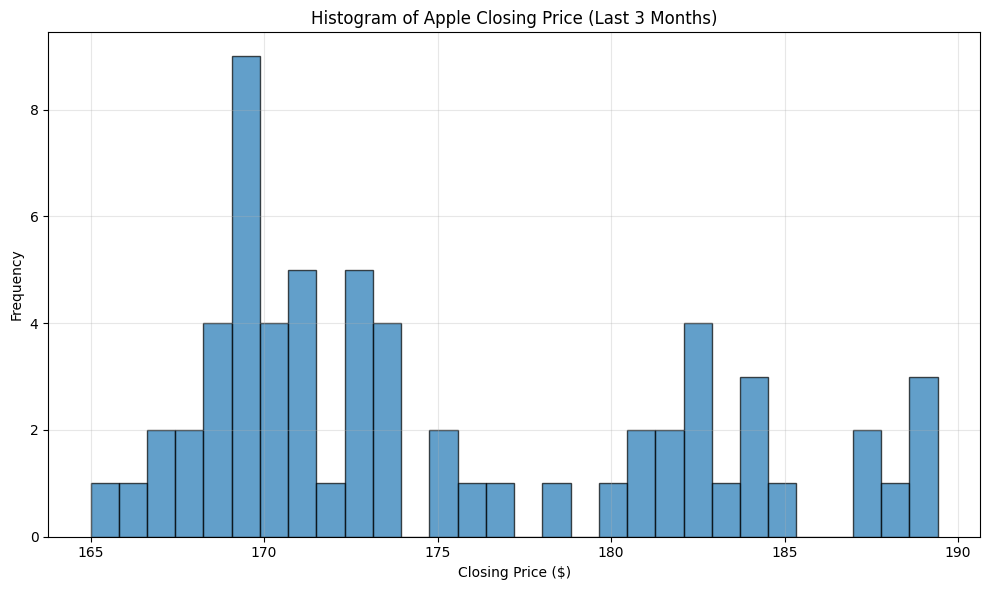

In [15]:
# Plot the histogram of Apple's closing price over the last 3 months 
plt.figure(figsize=(10, 6))
plt.hist(apple_last_3_months['Close/Last'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Closing Price ($)')
plt.ylabel('Frequency')
plt.title('Histogram of Apple Closing Price (Last 3 Months)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Calculating correlation between a stock price and a macroeconomic variable 

Inflation affects the purchasing power of money and can influence corporate profits, interest rates, and consumer behavior. By analyzing the correlation between stock prices and inflation, one can gauge how inflationary trends impact stock market performance. For instance, high inflation might erode profit margins and reduce stock prices, while moderate inflation might indicate a growing economy, benefiting stocks.

Your task:
* Plot a heatmap that shows the correlation between Microsoft and Apple returns and inflation 

This will require several steps:
1. Calculate the returns for Apple and Microsoft and the change in monthly inflation (use the `pct_change` method for each)
2. Interpolate the daily stock returns data to monthly so it can be compared to the monthly inflation data
3. Merge the stock returns (Apple and Microsoft) and inflation data series into a single dataframe
4. Calculate the correlation matrix between the Apple returns, Microsoft returns, and inflation change
5. Plot the correlation matrix as a heatmap

### 1. Calculate returns for Microsoft / Apple and the monthly change in inflation

In [16]:
# Calculate daily returns for Apple and Microsoft and the percent change in inflation from month to month
# Ensure Date is set as index for stock data
apple_df_indexed = apple_df.set_index('Date').sort_index()
microsoft_df_indexed = microsoft_df.set_index('Date').sort_index()

# Calculate daily returns using pct_change
apple_returns = apple_df_indexed['Close/Last'].pct_change().dropna()
microsoft_returns = microsoft_df_indexed['Close/Last'].pct_change().dropna()

# Calculate monthly percent change in inflation
inflation_df_indexed = inflation_df.set_index('DATE')
inflation_pct_change = inflation_df_indexed['CORESTICKM159SFRBATL'].pct_change().dropna()

print("Apple returns sample:")
print(apple_returns.head())
print("\nMicrosoft returns sample:")
print(microsoft_returns.head())
print("\nInflation percent change sample:")
print(inflation_pct_change.head())


Apple returns sample:
Date
2014-05-07   -0.003768
2014-05-08   -0.007092
2014-05-09   -0.004286
2014-05-12    0.012434
2014-05-13    0.001889
Name: Close/Last, dtype: float64

Microsoft returns sample:
Date
2014-05-07    0.009345
2014-05-08    0.005453
2014-05-09   -0.002523
2014-05-12    0.010875
2014-05-13    0.011258
Name: Close/Last, dtype: float64

Inflation percent change sample:
DATE
1968-02-29    0.006013
1968-03-31    0.127482
1968-04-30    0.003299
1968-05-31   -0.016262
1968-06-30    0.111863
Name: CORESTICKM159SFRBATL, dtype: float64


### 2. Interpolate stock returns from daily to monthly

In [17]:
# Interpolate stock returns from daily to monthly
# For stock returns, we need to compound daily returns to get true monthly returns
# Formula: (1 + r1) * (1 + r2) * ... * (1 + rn) - 1
# This gives the cumulative return over the month, not just the last day's return

def compound_returns(returns_series):
    """
    Compound daily returns to get monthly return.
    Returns the cumulative return: (1 + r1) * (1 + r2) * ... * (1 + rn) - 1
    """
    return (1 + returns_series).prod() - 1

# Apply compounding function to each month
# Using 'M' for month-end (works in pandas < 2.0; 'ME' requires pandas >= 2.0)
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=FutureWarning)
    apple_returns_monthly = apple_returns.resample('M').apply(compound_returns)
    microsoft_returns_monthly = microsoft_returns.resample('M').apply(compound_returns)

print("Apple monthly returns sample (compounded):")
print(apple_returns_monthly.head())
print("\nMicrosoft monthly returns sample (compounded):")
print(microsoft_returns_monthly.head())


Apple monthly returns sample (compounded):
Date
2014-05-31    0.065002
2014-06-30    0.027421
2014-07-31    0.028842
2014-08-31    0.072385
2014-09-30   -0.017167
Freq: M, Name: Close/Last, dtype: float64

Microsoft monthly returns sample (compounded):
Date
2014-05-31    0.048131
2014-06-30    0.018564
2014-07-31    0.035012
2014-08-31    0.052595
2014-09-30    0.020471
Freq: M, Name: Close/Last, dtype: float64


### 3. Merge the dataframes and calculate / plot the correlation

In [18]:
# Merge the dataframes and calculate / plot the correlation
# Create dataframes with proper column names for merging
correlation_df = pd.DataFrame({
    'Apple_Returns': apple_returns_monthly,
    'Microsoft_Returns': microsoft_returns_monthly,
    'Inflation_Change': inflation_pct_change
})

# Merge on the date index
correlation_df = correlation_df.dropna()

print("Merged correlation dataframe:")
print(correlation_df.head())
print(f"\nShape: {correlation_df.shape}")


Merged correlation dataframe:
            Apple_Returns  Microsoft_Returns  Inflation_Change
2014-05-31       0.065002           0.048131          0.050251
2014-06-30       0.027421           0.018564          0.007147
2014-07-31       0.028842           0.035012         -0.020724
2014-08-31       0.072385           0.052595         -0.066387
2014-09-30      -0.017167           0.020471         -0.004516

Shape: (119, 3)


### 4. Calculate the correlation matrix between the Apple returns, Microsoft returns, and inflation change

In [19]:
# Calculate correlation matrix
correlation_matrix = correlation_df.corr()
print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                   Apple_Returns  Microsoft_Returns  Inflation_Change
Apple_Returns           1.000000           0.588237         -0.074699
Microsoft_Returns       0.588237           1.000000         -0.070176
Inflation_Change       -0.074699          -0.070176          1.000000


### 5. Plot the correlation matrix as a heatmap 

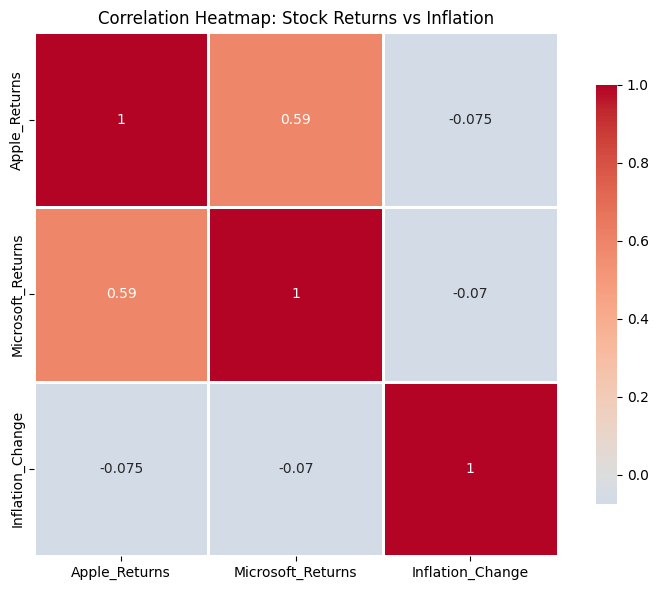

In [20]:
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap: Stock Returns vs Inflation')
plt.tight_layout()
plt.show()


## Calculating rolling volatility (standard deviation) of a stock's returns for last 3 months

Volatility is a measure of the dispersion of returns for a given security. By calculating rolling volatility, investors can assess the risk associated with a stock over time: Higher volatility indicates higher risk, as the stock's price is more likely to experience significant fluctuations. In portfolio optimization, understanding the volatility of individual stocks and how it changes over time is crucial for diversification and optimization. By analyzing rolling volatility, investors can adjust their portfolios to maintain a desired risk level, potentially improving the risk-return profile.

**Important**: Volatility must be calculated from returns (percentage changes), not from prices. Prices trend over time, which would distort volatility measurements. Returns normalize price movements and provide an accurate measure of risk.

Your task:
* Calculate the weekly rolling standard deviation for Apple's returns (not prices)
* Plot the calculated rolling weekly volatility of Apple's returns against Apple's closing price. Plot these **on the same chart, but using different y-axes**

Helpful hints:
* You'll need to use the `pandas` `rolling()` method with a given `window_size` parameter to make it a _weekly_ rolling calculation
* Calculate rolling volatility on the **full dataset first**, then trim to the last three months for plotting (this ensures all windows have sufficient data)
* You'll need to create two axes on the matplotlib figure to be able to use two different y-axes (one for the closing price and one for the rolling volatility calculated here)

In [21]:
# Define the window size for the rolling calculation (e.g., one week)
window_size = 5  # 5 trading days = approximately one week


In [22]:
# Calculate rolling one-week volatility from RETURNS (not prices)
# IMPORTANT: Calculate on full dataset first, then trim to 3 months
# This ensures all rolling windows have sufficient historical data

# Calculate rolling volatility of returns on the full dataset
rolling_volatility_full = apple_returns.rolling(window=window_size).std()

# Now trim to the last 3 months for plotting
max_date = apple_df_indexed.index.max()
three_months_ago = max_date - pd.DateOffset(months=3)
rolling_volatility = rolling_volatility_full[rolling_volatility_full.index >= three_months_ago]

# Also get the last 3 months of prices for plotting
apple_last_3_months_indexed = apple_df_indexed[apple_df_indexed.index >= three_months_ago]

print("Rolling volatility sample (from returns, last 3 months):")
print(rolling_volatility.head(10))
print(f"\nRolling volatility date range: {rolling_volatility.index.min()} to {rolling_volatility.index.max()}")


Rolling volatility sample (from returns, last 3 months):
Date
2024-02-05    0.015513
2024-02-06    0.013633
2024-02-07    0.007636
2024-02-08    0.007444
2024-02-09    0.006342
2024-02-12    0.006990
2024-02-13    0.006063
2024-02-14    0.005367
2024-02-15    0.005656
2024-02-16    0.003826
Name: Close/Last, dtype: float64

Rolling volatility date range: 2024-02-05 00:00:00 to 2024-05-03 00:00:00


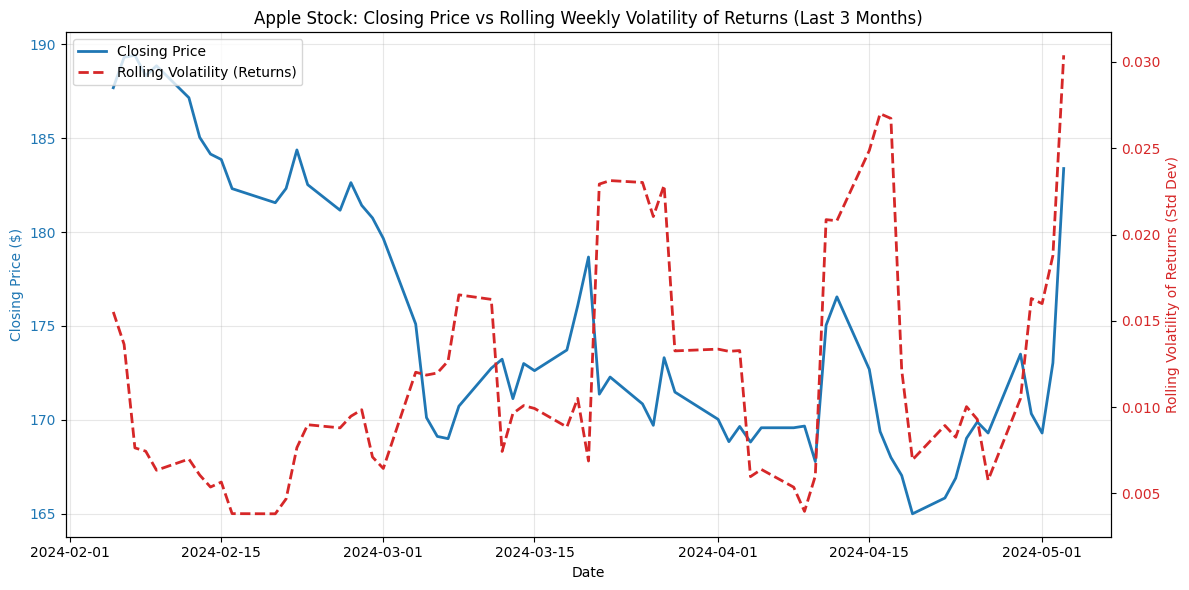

In [23]:
# Plot the calculated rolling weekly volatility of Apple's returns against Apple's closing price
# Plot these on the same chart, but using different y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot closing price on left y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Price ($)', color=color)
line1 = ax1.plot(apple_last_3_months_indexed.index, apple_last_3_months_indexed['Close/Last'], 
                 color=color, label='Closing Price', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Create second y-axis for volatility (calculated from returns)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Rolling Volatility of Returns (Std Dev)', color=color)
line2 = ax2.plot(rolling_volatility.index, rolling_volatility, 
                 color=color, label='Rolling Volatility (Returns)', linewidth=2, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

# Add legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.title('Apple Stock: Closing Price vs Rolling Weekly Volatility of Returns (Last 3 Months)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Export data

Now that you have preprocessed your data, you should save it in new csv files so that it can be used in downstream tasks without having to redo all the preprocessing steps. 

Your task:
* Use `pandas` to export all modified datasets back to new CSV files

In [24]:
# Export all modified datasets to CSV files
# Reset indices where needed for cleaner CSV output

# Export GDP data
gdp_df.to_csv('GDP_processed.csv', index=False)

# Export inflation data (monthly, weekly, quarterly)
inflation_df.to_csv('inflation_monthly_processed.csv', index=False)
inflation_weekly.reset_index().to_csv('inflation_weekly_processed.csv', index=False)
inflation_quarterly.reset_index().to_csv('inflation_quarterly_processed.csv', index=False)


apple_returns_monthly.to_csv('apple_returns_monthly_processed.csv', index=False)
microsoft_returns_monthly.to_csv('microsoft_returns_monthly_processed.csv', index=False)
rolling_volatility.to_csv('rolling_volatility_processed.csv', index=False)
correlation_matrix.to_csv('correlation_matrix_processed.csv', index=False)

# Export stock data
apple_df.to_csv('apple_historical_data_processed.csv', index=False)
microsoft_df.to_csv('microsoft_historical_data_processed.csv', index=False)

# Export CPI data
cpi_df.to_csv('consumer_price_index_processed.csv', index=False)

# Export correlation data
correlation_df.reset_index().to_csv('correlation_data.csv', index=False)

print("All datasets have been exported to CSV files.")


All datasets have been exported to CSV files.
